In [1]:
import pandas as pd
import requests as rq

url = 'https://servicodados.ibge.gov.br/api/v1/localidades/estados/pa/municipios'
   
res = rq.request("GET", url)

#Creates a data frame with the Municipalities column.
if res.status_code == 200:
    df_munic = pd.DataFrame({'id': [], 'localidade': []})
    
    for id, munic in enumerate(res.json()):
        df_munic.loc[id] = [str(munic['id'])[:6], munic['nome']]


In [2]:
indicators = ['90201','90335','90358','90626','90640']

url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/1/periodos/2019/indicadores/"

# Adding indicators to the end of the url
for i, ind in enumerate(indicators):
    if i != (len(indicators)-1):
        url += ind + '|'
    else:
        url += ind + '/'
        
# Function to Formatting final url
def urlResultadosPorMunicipos(url, df):
    url += 'resultados/'    

    for i, row in df_munic.iterrows():
        if i != (len(df)-1):
            url += row.id + '|'
        else:
            url += row.id + '/'
    
    return url


url = urlResultadosPorMunicipos(url, df_munic)

# return json results
res = rq.request("GET", url)


In [3]:
if res.status_code == 200:
    
    #Scrolls through the json and inserts the data into the main dataframe for each selected indicator.
    for indicador in res.json():
        df_temp = pd.DataFrame(indicador['res'])
        df_temp = df_temp[['localidade', 'res']]
        df_temp.rename(columns = {'localidade':'id', 'res': indicador['id']}, inplace = True)
        
        #It replaces the words "Yes" and "No" with binary information 1 and 0.
        df_temp[indicador['id']] = df_temp[indicador['id']].map(lambda x: 1 if x['2019']  == 'Sim' else 0)
        df_munic = pd.merge(df_munic, df_temp, on="id")

In [4]:
df_munic['Rede_de_Protecao_assistencia'] = df_munic[90201] + df_munic[90335] + df_munic[90358] + df_munic[90626] + df_munic[90640]
df_munic = df_munic[['id', 'localidade', 'Rede_de_Protecao_assistencia']]

In [5]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/37/periodos/2010/indicadores/30255/"

url = urlResultadosPorMunicipos(url, df_munic)
        
res = rq.request("GET", url)

# correction of missing values
x = res.json()
x[0]['res'][73]['res']['2010'] = '0'
x

df_temp = pd.json_normalize(x[0]['res'])
df_temp.rename(columns={'localidade': 'id', 'res.2010': 'IDH'}, inplace=True)
df_temp = df_temp[['id', 'IDH']]
df_munic = pd.merge(df_munic, df_temp, on='id')

In [6]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/38/periodos/2019/indicadores/47001/"

url = urlResultadosPorMunicipos(url, df_munic)   
res = rq.request("GET", url)
df_temp = pd.json_normalize(res.json()[0]['res'])
df_temp.rename(columns={'localidade': 'id', 'res.2019': 'PIB'}, inplace=True)
df_temp = df_temp[['id', 'PIB']]
df_munic = pd.merge(df_munic, df_temp, on='id')

In [7]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/36/periodos/2003/indicadores/30252/"

url = urlResultadosPorMunicipos(url, df_munic)
        
res = rq.request("GET", url)
# correction of missing values
x = res.json()
x[0]['res'].append({'localidade': '150475', 'res': {'2003': '0.00'}, 'notas': {'2003': None}})

df_temp = pd.json_normalize(x[0]['res'])
df_temp.rename(columns={'localidade': 'id', 'res.2003': 'GINI'}, inplace=True)
df_temp = df_temp[['id', 'GINI']]
df_munic = pd.merge(df_munic, df_temp, on='id', how='left')

In [8]:
df_munic['Rede_de_Protecao_assistencia'] = pd.to_numeric(df_munic['Rede_de_Protecao_assistencia'])
df_munic['IDH'] = pd.to_numeric(df_munic['IDH'])
df_munic['PIB'] = pd.to_numeric(df_munic['PIB'])
df_munic['GINI'] = pd.to_numeric(df_munic['GINI'])

In [9]:
#cols = df_munic[['Rede_de_Protecao_assistencia', 'IDH', 'PIB', 'GINI']]

def normalize(df_columns):
    for i in df_columns:
        mx = df_munic[[i]].max()[0]
        mn = df_munic[[i]].min()[0]
        df_munic[[i]] = (df_munic[[i]] - mn) / (mx - mn)

def deNormalize(df_columns, dmin, dmax):
    for i in df_columns:
        df_munic[[i]] = df_munic[[i]] * (dmax - dmin) + dmin

#normalize(cols)
normalize(df_munic.iloc[:,2:].columns)

In [10]:
df_munic.iloc[:,2:].describe()

,Rede_de_Protecao_assistencia,IDH,PIB,GINI
count,144.000000,144.000000,144.000000,144.000000
mean,0.277778,0.774138,0.044827,0.761196
std,0.236656,0.099055,0.117906,0.081778
min,0.000000,0.000000,0.000000,0.000000
25%,0.150000,0.732909,0.010107,0.734694
50%,0.200000,0.780831,0.018945,0.775510
75%,0.400000,0.822386,0.037740,0.795918
max,1.000000,1.000000,1.000000,1.000000


[[0.0, 0.6072386058981234, 0.0, 0.6734693877551021],
 [0.15000000000000002,
  0.7329088471849866,
  0.010107113043029458,
  0.7346938775510204],
 [0.2, 0.7808310991957104, 0.01894514113870411, 0.7755102040816326],
 [0.4, 0.8223860589812333, 0.03774022954802127, 0.7959183673469388],
 [0.6, 0.9262734584450402, 0.07872065194724878, 0.8775510204081632]]

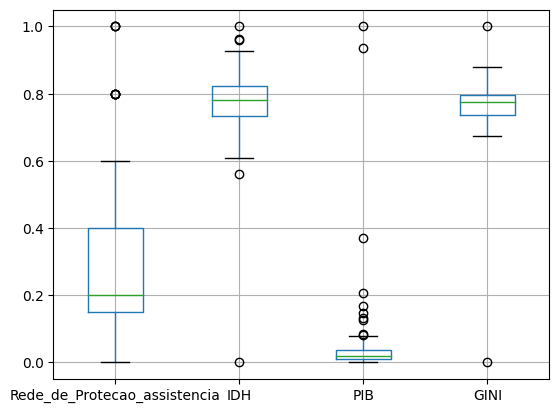

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def create_boxplot(dataset):

    Q3 = np.quantile(dataset, 0.75)
    Q1 = np.quantile(dataset, 0.25)
    MEDIAN = np.quantile(dataset, 0.50)
    IQR = Q3 - Q1

    lower_range = Q1 - 0.15 * IQR
    upper_range = Q3 + 0.15 * IQR

    while lower_range < 0:
        dst = dataset[dataset[dataset.columns[0]] > Q1]
        
        Q3 = np.quantile(dst, 0.75)
        Q1 = np.quantile(dst, 0.25)
        MEDIAN = np.quantile(dst, 0.50)
        IQR = Q3 - Q1
    
        lower_range = Q1 - 0.15 * IQR
        upper_range = Q3 + 0.15 * IQR

        dataset = dst
        
    print(f"Q3 = {Q3}")
    print(f"Q1 = {Q1}")
    print(f"IQR = {IQR}")
    print(f"Median = {MEDIAN}")
    print(f"Lower_Range = {lower_range}")
    print(f"Upper_Range = {upper_range}")

    ax = sns.boxplot(dataset, orient="h")
    plt.xlim(0, 1)
    plt.show()
    


def print_limits(dataset) -> list:

    res = np.zeros((5, 4))

    #boxplot create
    _, bp = pd.DataFrame.boxplot(dataset, return_type='both')
    caps = [cap.get_ydata() for cap in bp["caps"]] # limites inferior e superior
    outliers = [flier.get_ydata() for flier in bp["fliers"]]  # Desconsiderar
    boxes = [box.get_ydata() for box in bp["boxes"]] # Q1 e Q3
    medians = [median.get_ydata() for median in bp["medians"]] # Mediana
    whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]] # Q1 Q3 LimSup LimInf
    
    cont = 0
    for c in range(0, len(whiskers), 2):
        lower_range = whiskers[c][1]

        Q1 = whiskers[c][0]
        M = medians[cont][0]
        Q3 = whiskers[c+1][0]

        upper_range = whiskers[c+1][1]

        

        res[0][cont] = lower_range
        res[1][cont] = Q1
        res[2][cont] = M
        res[3][cont] = Q3
        res[4][cont] = upper_range

        cont += 1
    
    
    return res.tolist()
         

print_limits(df_munic.iloc[:,2:])

In [12]:
sns.histplot(df_munic.iloc[:,2:3], kde=True)


<AxesSubplot: ylabel='Count'>

Q3 = 0.4
Q1 = 0.15000000000000002
IQR = 0.25
Median = 0.2
Lower_Range = 0.11250000000000002
Upper_Range = 0.4375


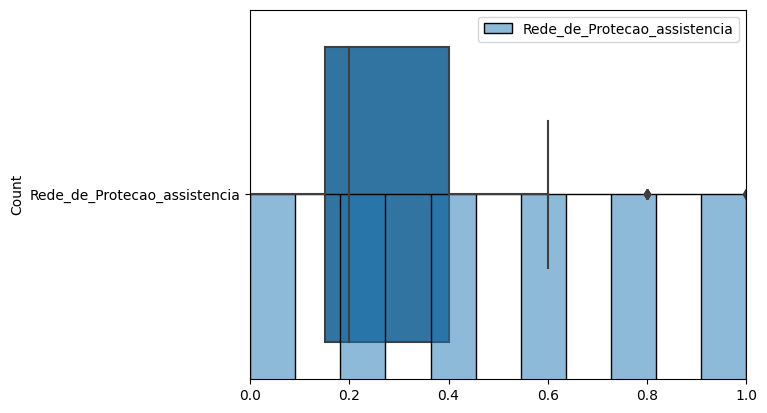

In [13]:
create_boxplot(df_munic.iloc[:,2:3])

In [14]:
sns.histplot(df_munic.iloc[:,3:4], kde=True)


<AxesSubplot: ylabel='Count'>

Q3 = 0.8223860589812333
Q1 = 0.7329088471849866
IQR = 0.08947721179624668
Median = 0.7808310991957104
Lower_Range = 0.7194872654155496
Upper_Range = 0.8358076407506703


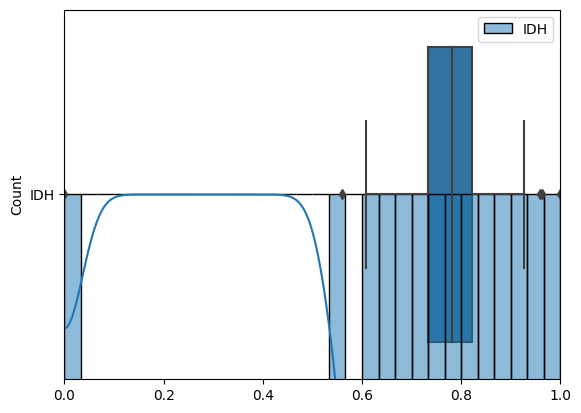

In [15]:
create_boxplot(df_munic.iloc[:,3:4])


In [16]:
sns.histplot(df_munic.iloc[:,4:5], kde=True)


<AxesSubplot: ylabel='Count'>

Q3 = 0.03774022954802127
Q1 = 0.010107113043029458
IQR = 0.02763311650499181
Median = 0.01894514113870411
Lower_Range = 0.005962145567280686
Upper_Range = 0.04188519702377004


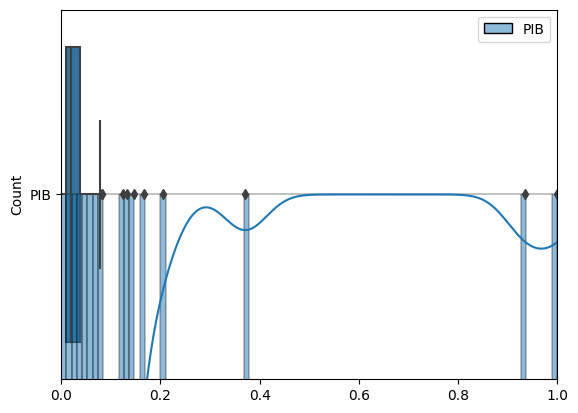

In [17]:
create_boxplot(df_munic.iloc[:,4:5])

In [18]:
sns.histplot(df_munic.iloc[:,5:6], kde=True)

<AxesSubplot: ylabel='Count'>

Q3 = 0.7959183673469388
Q1 = 0.7346938775510204
IQR = 0.061224489795918324
Median = 0.7755102040816326
Lower_Range = 0.7255102040816327
Upper_Range = 0.8051020408163265


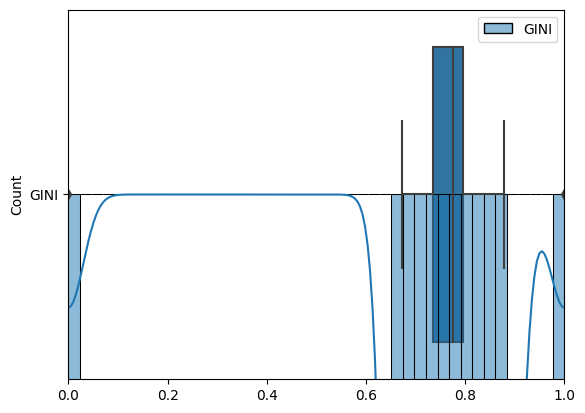

In [19]:
create_boxplot(df_munic.iloc[:,5:6])

In [20]:
     #IP       #IDH      #PIB      #GINI
Q = [0.05,      0.05,       0.05,      0.05]
P = [0.08,      0.08,       0.08,      0.08]
V = [2.0,      2.0,       2.0,      2.0]
W = [0.5,      0.5,       0.5,      0.5]

B = print_limits(df_munic.iloc[:,2:6])

np.array(B)

array([[0.        , 0.60723861, 0.        , 0.67346939],
       [0.15      , 0.73290885, 0.01010711, 0.73469388],
       [0.2       , 0.7808311 , 0.01894514, 0.7755102 ],
       [0.4       , 0.82238606, 0.03774023, 0.79591837],
       [0.6       , 0.92627346, 0.07872065, 0.87755102]])

In [21]:
T = df_munic.iloc[:, 2:].values

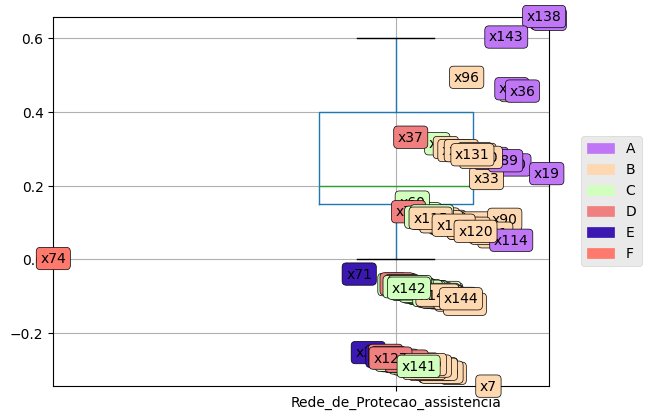

In [22]:
from pyDecision.algorithm import electre_tri_b

classification = electre_tri_b(T, W , Q , P , V , B, cut_level = 0.7, verbose = False, rule = 'oc', graph = True)

In [23]:
classification.count(0)

11

In [24]:
df_munic['CLASS'] = classification

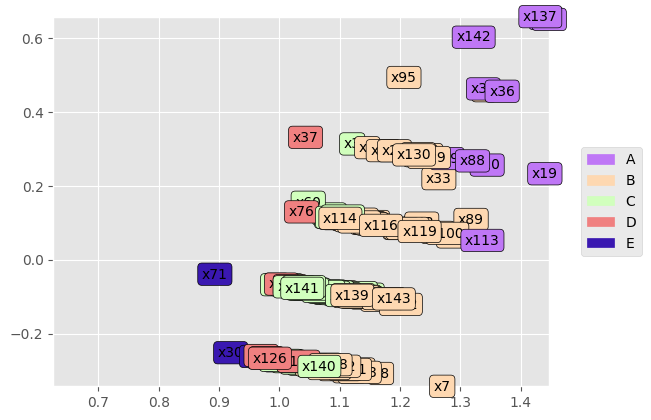

In [25]:
df__ = df_munic.query('CLASS != 5')

df_ = df__.iloc[:, 2:6]


c = electre_tri_b(np.array(df_), W , Q , P , V , B, cut_level = 0.7, verbose = False, rule = 'oc', graph = True)


In [26]:
df_munic = df_munic.rename(index=lambda s: 'x' + str(s + 1))

In [27]:
df_munic.query('CLASS == 0')

,id,localidade,Rede_de_Protecao_assistencia,IDH,PIB,GINI,CLASS
x10,150080,Ananindeua,0.6,0.962466,0.035283,0.775510,0
x18,150130,Barcarena,1.0,0.887399,0.132871,0.836735,0
x19,150140,Belém,0.6,1.000000,0.057528,0.877551,0
x34,150220,Capanema,0.8,0.878016,0.037583,0.775510,0
x36,150240,Castanhal,0.8,0.902145,0.051893,0.795918,0
x66,150420,Marabá,1.0,0.895442,0.125115,0.836735,0
x69,150442,Marituba,0.6,0.906166,0.033082,0.734694,0
x89,150550,Paragominas,0.6,0.864611,0.078721,0.836735,0
x114,150680,Santarém,0.4,0.926273,0.040286,0.877551,0
x138,150810,Tucuruí,1.0,0.892761,0.145617,0.816327,0


In [28]:
import geopandas as gpd

gdf_munic = gpd.read_file('json/munics.geojson')

for value in gdf_munic['id']:
    gdf_munic['id'].replace(to_replace=value, value=value[:6], regex=True,inplace=True)


df_teste = pd.merge(df_munic, gdf_munic, on='id', how='left')

df_teste = df_teste[['id', 'localidade', 'geometry']]

df_teste['classe'] = classification

In [29]:
clusdict={5: '1 - Extremely High', 4: '2 - Very High', 3: '3 - High', 2: '4 - Medium', 1: '5 - Low', 0: '6 - Very Low' }
df_teste['legenda'] = df_teste['classe'].map(clusdict)
df_teste['classe'] = classification

gpd_teste = gpd.GeoDataFrame(df_teste)

ax = gpd_teste.plot(column='legenda', categorical=True, legend=True, legend_kwds={'loc': 'upper right'}, figsize=(10,10), cmap='prism')

def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

replace_legend_items(ax.get_legend(), clusdict)

ax.set_axis_off()

In [30]:
denuncias = pd.read_json('json/casos_violencia_por_municipio.json')
denuncias = denuncias.rename(index=lambda s: 'x' + str(s + 1))

df_munic['denuncias'] = denuncias['casos']

In [31]:
df_munic

,id,localidade,Rede_de_Protecao_assistencia,IDH,PIB,GINI,CLASS,denuncias
x1,150010,Abaetetuba,0.8,0.841823,0.014360,0.816327,1,77
x2,150013,Abel Figueiredo,0.2,0.833780,0.021286,0.755102,1,0
x3,150020,Acará,0.6,0.678284,0.028919,0.734694,2,11
x4,150030,Afuá,0.6,0.655496,0.014173,0.795918,1,1
x5,150034,Água Azul do Norte,0.2,0.756032,0.036816,0.755102,2,4
...,...,...,...,...,...,...,...,...
x140,150815,Uruará,0.2,0.789544,0.028277,0.775510,1,2
x141,150820,Vigia,0.0,0.827078,0.006443,0.734694,2,10
x142,150830,Viseu,0.2,0.690349,0.009042,0.755102,2,4
x143,150835,Vitória do Xingu,0.8,0.798928,0.935595,0.775510,0,6


In [32]:
data = df_munic

sns.set_style("whitegrid")
 
# depict visualization
gfg = sns.boxplot(x="Rede_de_Protecao_assistencia", y="denuncias", data=data, palette='hot_r')

gfg.set_ylim(0, 120)
gfg.set(xlabel ="Support and Protection Index (IAP)", ylabel = "Denunciations")



[Text(0.5, 89.68626392038504, 'Support and Protection Index (IAP)'),
 Text(80.47222222222221, 0.5, 'Denunciations')]